## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [7]:
print(mylist[1000])

03-02-06-02-02-02-12.wav


In [8]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [12]:
data, sampling_rate = librosa.load('RawData/03-02-06-02-02-02-12.wav')

Populating the interactive namespace from numpy and matplotlib


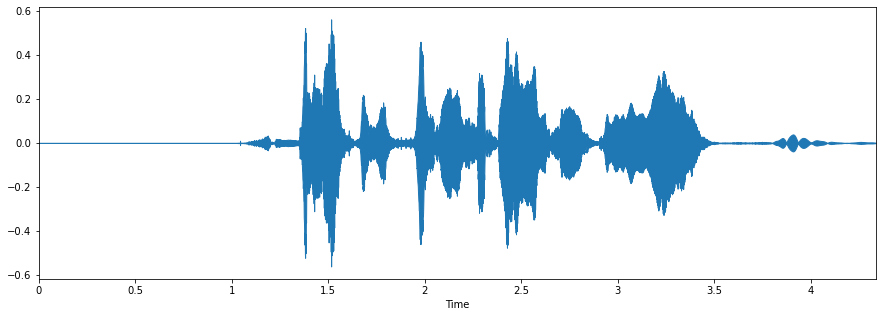

In [14]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<ipython-input-16-5453e3124de9>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-02-06-02-02-02-12.wav')
<ipython-input-16-5453e3124de9>:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


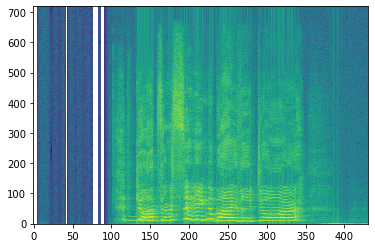

In [16]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-02-06-02-02-02-12.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [17]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [18]:
labels = pd.DataFrame(feeling_list)

In [19]:
labels[:10]

0
0    male_calm
1  female_calm
2    male_calm
3  female_calm
4    male_calm
5  female_calm
6    male_calm
7  female_calm
8    male_calm
9  female_calm

## Getting the features of audio files using librosa

In [20]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [21]:
df[:5]

feature
0  [-61.542942, -61.67029, -61.663513, -61.675594...
1  [-59.344055, -59.344055, -59.344055, -59.34405...
2  [-48.954494, -48.82861, -49.6816, -52.03216, -...
3  [-60.07603, -60.313347, -59.857048, -57.80332,...
4  [-60.01485, -62.686897, -65.488106, -60.48127,...

In [22]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [23]:
newdf = pd.concat([df3,labels], axis=1)

In [24]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [25]:
rnewdf[:5]

0          1          2          3          4          5    \
0 -61.542942 -61.670292 -61.663513 -61.675594 -59.627464 -58.578274   
1 -59.344055 -59.344055 -59.344055 -59.344055 -59.344055 -59.344055   
2 -48.954494 -48.828609 -49.681599 -52.032162 -48.399113 -47.975899   
3 -60.076031 -60.313347 -59.857048 -57.803322 -58.947754 -59.264015   
4 -60.014851 -62.686897 -65.488106 -60.481270 -60.038151 -64.788376   

         6          7          8          9    ...        207        208  \
0 -60.384644 -60.370815 -59.209068 -59.793682  ... -32.029648 -28.536741   
1 -59.344055 -59.344055 -59.344055 -59.344055  ... -42.964802 -43.955097   
2 -49.650616 -51.260963 -49.758038 -50.975227  ... -23.577650 -24.113665   
3 -57.992619 -57.401936 -57.059830 -57.166061  ... -42.776798 -40.195335   
4 -66.386238 -61.152500 -58.949646 -59.597214  ... -43.592575 -42.287838   

         209        210        211        212        213        214  \
0 -27.502647 -26.418858 -27.831207 -28.752033 -28.786449 -21.615858   
1 -44.208008 -43.749870 -42.165371 -43.236347 -43.611912 -20.658558   
2 -22.895826 -22.712572 -24.839592 -27.322344 -28.557560 -28.592690   
3 -38.818481 -39.010696 -41.907330 -42.493778 -43.464279 -36.841316   
4 -42.087948 -42.331047 -40.317867 -37.837944 -35.932858 -32.704998   

         215          0    
0 -17.308699    male_calm  
1 -12.422130  female_calm  
2 -25.435741    male_calm  
3 -29.907366  female_calm  
4 -28.022449    male_calm  

[5 rows x 217 columns]

In [26]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

0          1          2          3          4          5    \
419 -67.574844 -67.574844 -67.574844 -67.574844 -67.574844 -67.574844   
347 -38.331001 -41.907475 -44.766216 -45.256756 -44.771591 -43.600044   
502 -53.980591 -53.863071 -55.297249 -55.568996 -53.815231 -53.594612   
430 -42.622025 -43.579628 -45.190411 -46.336689 -45.783039 -44.085327   
20  -45.357254 -42.959389 -43.516418 -47.538902 -51.361103 -52.117329   
673 -50.489662 -50.906857 -51.399574 -51.399574 -50.286842 -49.145241   
241 -53.716934 -53.972878 -53.181664 -53.558559 -54.397457 -51.155869   
474 -53.052555 -52.273540 -52.967510 -55.345634 -55.556664 -53.445194   
357 -55.292011 -55.635391 -57.176857 -57.176857 -56.642967 -54.960415   
85  -52.621971 -50.284481 -50.559044 -51.060989 -52.841438 -52.799778   

           6          7          8          9    ...        207        208  \
419 -67.574844 -67.574844 -67.574844 -67.574844  ... -49.959904 -51.298141   
347 -43.581089 -44.235798 -46.262207 -45.795433  ... -22.051973 -22.052921   
502 -51.804630 -50.267704 -50.514957 -49.740784  ... -27.312580 -26.760136   
430 -44.473713 -43.117271 -44.641758 -45.731403  ... -31.506706 -31.214853   
20  -50.644184 -50.441898 -50.054035 -48.655197  ... -38.794064 -39.372719   
673 -48.149502 -47.568195 -47.962830 -47.900120  ... -20.919106 -23.703493   
241 -47.766846 -48.338928 -49.246017 -48.674454  ... -36.598652 -35.003216   
474 -51.471062 -51.712276 -53.809471 -55.181190  ... -37.994366 -39.485836   
357 -55.876045 -56.641342 -56.299973 -55.034893  ... -28.692434 -29.996843   
85  -51.159706 -50.258537 -51.640621 -52.730156  ... -29.583078 -29.017311   

           209        210        211        212        213        214  \
419 -52.195721 -51.200710 -47.806763 -48.544357 -47.354431 -34.162224   
347 -23.249073 -22.835602 -25.532917 -26.218395 -22.813313 -17.740131   
502 -26.864445 -28.179508 -28.543629 -28.108103 -28.468113 -18.224892   
430 -30.243380 -31.379059 -25.286724 -22.188061 -22.662079 -21.875090   
20  -37.833382 -36.183270 -36.634178 -38.928658 -38.169319 -31.944521   
673 -24.060059 -22.374279 -22.169950 -23.010118 -24.164625 -26.510359   
241 -37.495651 -39.526485 -39.820679 -41.155258 -42.694405 -28.852785   
474 -39.067749 -33.886135 -32.327179 -28.574869 -25.577639 -24.497021   
357 -33.079800 -31.402342 -31.153471 -31.440350 -30.532707 -24.362255   
85  -27.893064 -27.504864 -26.582684 -26.909864 -27.713213 -20.382338   

           215           0    
419 -26.604841    female_sad  
347 -12.751250    male_happy  
502 -13.195655      male_sad  
430 -17.969633      male_sad  
20  -26.355284   female_calm  
673 -30.958609    male_angry  
241 -21.370258  female_happy  
474 -20.466448      male_sad  
357 -19.327013    male_happy  
85  -16.442745     male_calm  

[10 rows x 217 columns]

In [27]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [28]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [29]:
train[250:260]

0          1          2          3          4          5    \
517 -50.286125 -49.724319 -49.976723 -50.427464 -50.694893 -48.572475   
709 -43.671452 -45.185501 -44.070145 -43.422935 -42.905144 -42.078758   
324 -37.292500 -39.941544 -42.253044 -42.241604 -43.236721 -44.440609   
828 -51.925014 -50.482735 -50.104336 -51.994728 -53.954281 -53.447403   
684 -49.922585 -47.564087 -47.027061 -46.733109 -47.265465 -48.946121   
807 -50.080288 -51.960430 -52.676601 -53.054451 -53.789646 -53.789646   
421 -54.136929 -53.853901 -53.048286 -51.536758 -50.300209 -48.003273   
17  -66.059891 -60.052071 -59.326359 -61.271362 -58.107674 -57.000404   
162 -57.643257 -57.643257 -57.643581 -57.643257 -57.643257 -57.643257   
432 -63.768105 -63.768105 -63.768105 -63.768105 -63.768105 -63.768105   

           6          7          8          9    ...        207        208  \
517 -48.053596 -48.341267 -48.119289 -47.071026  ... -42.149273 -43.022461   
709 -41.800026 -41.261681 -41.562874 -45.346470  ... -19.254465 -19.209846   
324 -44.100220 -45.239483 -44.277607 -44.579994  ... -21.832018 -21.124073   
828 -51.927692 -51.877956 -53.078091 -53.253517  ... -26.198635 -28.088930   
684 -50.338737 -49.479622 -49.222858 -50.311119  ... -22.311226 -21.935221   
807 -52.981392 -51.868294 -49.291397 -46.454304  ... -23.498363 -21.596531   
421 -50.080009 -52.130447 -49.484234 -49.321476  ... -40.333652 -39.305122   
17  -56.364769 -56.759636 -56.917381 -58.115078  ... -30.768480 -30.895098   
162 -57.643257 -57.643257 -57.643257 -57.643257  ... -46.717205 -45.317093   
432 -63.768105 -63.768105 -63.768105 -63.768105  ... -46.888405 -47.226318   

           209        210        211        212        213        214  \
517 -43.518208 -43.952427 -44.830360 -43.096123 -43.148464 -26.333191   
709 -19.256699 -17.847649 -17.393621 -18.367918 -20.631636 -12.355373   
324 -20.868984 -20.729790 -22.331129 -22.584812 -20.713390 -12.222030   
828 -28.383026 -29.718781 -28.278400 -29.305759 -31.019484 -22.433128   
684 -19.462082 -16.956524 -16.775352 -20.145081 -24.586962 -25.872427   
807 -21.439358 -22.869040 -24.191132 -25.267454 -25.456308 -19.606699   
421 -38.556709 -39.082119 -36.471157 -35.808578 -34.564999 -22.201609   
17  -31.080803 -30.370230 -30.705452 -32.509514 -32.709190 -27.406277   
162 -42.927883 -44.548111 -45.088127 -43.467384 -43.025467 -28.498165   
432 -47.848129 -49.199497 -48.983170 -49.396481 -49.511387 -31.590847   

           215           0    
517 -18.607349    female_sad  
709  -7.934915    male_angry  
324  -6.051994    male_happy  
828 -18.039310  male_fearful  
684 -24.266768    male_angry  
807 -15.558043  male_fearful  
421 -16.032133    female_sad  
17  -22.456585     male_calm  
162 -20.792917   female_calm  
432 -23.428740    female_sad  

[10 rows x 217 columns]

In [30]:
trainfeatures = train.iloc[:, :-1]

In [31]:
trainlabel = train.iloc[:, -1:]

In [32]:
testfeatures = test.iloc[:, :-1]

In [33]:
testlabel = test.iloc[:, -1:]

In [34]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\python38\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [35]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
X_train.shape

(735, 216)

## Changing dimension for CNN model

In [37]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [40]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

AttributeError: module 'keras.optimizers' has no attribute 'rmsprop'

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_10 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_11 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 27, 128)          

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

NameError: name 'opt' is not defined

### Removed the whole training part for avoiding unnecessary long epochs list

In [43]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [44]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cnnhistory' is not defined

## Saving the model

In [45]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Witcher\Desktop\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [46]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [47]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


NameError: name 'opt' is not defined

## Predicting emotions on the test data

In [48]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

6/6 [==============================] - 0s 14ms/step


In [49]:
preds

array([[0.07472326, 0.00192756, 0.01746186, ..., 0.00237813, 0.03773837,
        0.00184282],
       [0.0860211 , 0.00867398, 0.06666492, ..., 0.01289931, 0.07916207,
        0.01148503],
       [0.10141674, 0.01404155, 0.07380988, ..., 0.01758873, 0.12437294,
        0.01192222],
       ...,
       [0.0911561 , 0.01373476, 0.08850917, ..., 0.01774165, 0.09539831,
        0.01854007],
       [0.12039635, 0.01259536, 0.0643582 , ..., 0.01654719, 0.0852748 ,
        0.01411522],
       [0.08279916, 0.00230863, 0.01696109, ..., 0.00274922, 0.0416387 ,
        0.00206752]], dtype=float32)

In [50]:
preds1=preds.argmax(axis=1)

In [51]:
preds1

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

In [52]:
abc = preds1.astype(int).flatten()

In [53]:
predictions = (lb.inverse_transform((abc)))

In [54]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

predictedvalues
0       male_calm
1       male_calm
2       male_calm
3       male_calm
4       male_calm
5       male_calm
6       male_calm
7       male_calm
8       male_calm
9       male_calm

In [55]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [56]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

actualvalues
0    female_sad
1     male_calm
2    male_angry
3    male_happy
4  female_angry
5   female_calm
6  female_angry
7  female_angry
8      male_sad
9  female_angry

In [57]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [58]:
finaldf[170:180]

actualvalues predictedvalues
170      female_sad       male_calm
171     female_calm       male_calm
172      male_angry       male_calm
173    male_fearful       male_calm
174      male_happy       male_calm
175        male_sad       male_calm
176    female_happy       male_calm
177     female_calm       male_calm
178  female_fearful       male_calm
179     female_calm       male_calm

In [59]:
finaldf.groupby('actualvalues').count()

predictedvalues
actualvalues                   
female_angry                 26
female_calm                  19
female_fearful               15
female_happy                 13
female_sad                   16
male_angry                   15
male_calm                    20
male_fearful                 17
male_happy                   23
male_sad                     21

In [60]:
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
male_calm                 185

In [61]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [62]:
data, sampling_rate = librosa.load('output10.wav')

In [63]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


In [64]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [65]:
livedf2= pd.DataFrame(data=livedf2)

In [66]:
livedf2 = livedf2.stack().to_frame().T

In [67]:
livedf2

0          1          2          3          4          5         6    \
           0          0          0          0          0          0         0   
0 -18.203562 -21.471832 -22.522209 -21.712259 -22.264282 -20.707907 -21.72644   

        7          8          9    ...        206       207        208  \
          0          0          0  ...          0         0          0   
0 -21.76865 -24.302736 -22.250633  ... -24.273817 -24.63994 -24.929155   

         209        210        211        212        213        214        215  
           0          0          0          0          0          0          0  
0 -24.439188 -25.210173 -24.740648 -22.311916 -22.579805 -22.314659 -21.552433  

[1 rows x 216 columns]

In [68]:
twodim= np.expand_dims(livedf2, axis=2)

In [69]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 991us/step


In [70]:
livepreds

array([[0.12435246, 0.03717817, 0.08554923, 0.11594859, 0.0952953 ,
        0.15414573, 0.23886693, 0.04207049, 0.07514475, 0.03144834]],
      dtype=float32)

In [71]:
livepreds1=livepreds.argmax(axis=1)

In [72]:
liveabc = livepreds1.astype(int).flatten()

In [73]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_calm'], dtype=object)